# AIAP Housing Price Assignment

# Part 1 - EDA

* Analyse Data and explain findings
* Clean Data and do filter methds (they work for all ml models)
* Use appropriate visualisations
e.g. sns.pairplot(df); maybe it implies a certain model can be used e.g. linear relationship??
* Explain what it means
* Explain implications


# Imports

In [1]:
# numerical libs and data handing
import numpy as np
import pandas as pd

# visualisation
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.manifold import TSNE

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import geohash2 # for latitude/longtitude feature engineering
# https://anaconda.org/conda-forge/geohash2

# Dimensionality Reduction
from sklearn.decomposition import PCA

# ML Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
import xgboost as xgb
#import sklearn.linear_model as linear_model
# neural networks?
# K-Nearest Neighbors vs KMeans
# random forest?

# Pipeline
from sklearn.pipeline import Pipeline

# ipython display
%matplotlib inline
#pd.options.display.max_rows = 1000
#pd.options.display.max_columns = 20

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore")

# Globals and Switches

In [2]:
# setting the number of cross validations used in the Model part 
cvNum = 5

# on/off switch for using log values for House Price and features     
use_logvals = 1    

# target used for correlation 
target = 'Y house price of unit area'

# attributes shortcuts
x1 = 'X1 transaction date'
x2 = 'X2 house age'
x3 = 'X3 distance to the nearest MRT station'
x4 = 'X4 number of convenience stores'
x5 = 'X5 latitude'
x6 = 'X6 longitude'

# only columns with correlation above this threshold value are used for the ML Regressors 
corr_Floor = 0.4    
    
# on/off switch for dropping columns that are similar to others already used and show a high correlation to these     
drop_similar = 1

# Functions

 # Load Data

In [3]:
df = pd.read_csv('https://aisgaiap.blob.core.windows.net/aiap4-assessment/real_estate.csv')

# Split Data into Train / Test sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop([target],axis=1), df[target], test_size=0.33, random_state=88)

# EDA

In [5]:
print('\nThe train dataset consists of {} rows and {} columns.'.format(df.shape[0],df.shape[1]))

print('\nThe columns are\n\n{}'.format(df.columns))
print('\nThe column "No" is a unique identifier that has no informational value to the machine learning model.')
print('The columns with "Xn" in it are attributes that may have informational value.')
print('The column with "Y" is the target variable')
      

print('\n\nA sample of 3 rows shows the following:\n{}'.format(df.sample(3)))


quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
print('\nQuantitative variables in this dataset are:\n{}'.format(quantitative))

qualitative = [f for f in df.columns if df.dtypes[f] == 'object']
print('\nQualitative variables in this dataset are:\n{}'.format(qualitative))

print('\nX and y are all numeric data, there is no need to transform / transcode the data.')


The train dataset consists of 414 rows and 8 columns.

The columns are

Index(['No', 'X1 transaction date', 'X2 house age',
       'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 latitude', 'X6 longitude',
       'Y house price of unit area'],
      dtype='object')

The column "No" is a unique identifier that has no informational value to the machine learning model.
The columns with "Xn" in it are attributes that may have informational value.
The column with "Y" is the target variable


A sample of 3 rows shows the following:
      No  X1 transaction date  X2 house age  \
53    54             2013.083          13.3   
179  180             2013.083          14.0   
76    77             2013.583          35.9   

     X3 distance to the nearest MRT station  X4 number of convenience stores  \
53                                 492.2313                                5   
179                                438.8513                                1  

# Data Cleansing

### Remove Identifier Columns
Remove columns that serve has unique identifiers as they add no informational value to the ML model


In [6]:
# Remove Identifier column/s
if 'No' in X_train:
    X_train.drop(['No'],axis=1,inplace=True)   


After removing the identifier columns, the housing price data consists of 7 attributes as follows:

X1 = the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.) - <i>categorical</i>

X2 = the house age (unit: year) - <i>quantitative</i>

X3 = the distance to the nearest MRT station (unit: meter) -  <i>quantitative</i>

X4 = the number of convenience stores in the living circle on foot (integer) - <i>quantitative</i>

X5 = the geographic coordinate, latitude. (unit: degree)

X6 = the geographic coordinate, longitude. (unit: degree)

-------------------------------------------------

The target variable is:
Y = house price of unit area (10000 New Taiwan Dollar/Ping, where Ping is a local unit, 1 Ping = 3.3 meter squared)

 

### Check for Missing Values

In [7]:
print('\nNumber of missing values are:\n{}'.format(df.isnull().sum()))
print('\nMost Machine Learning models do not handle missing values well. In this case, \nas \
there are no missing values, we do not need to consider if we should drop \nobservations or \
impute values')


Number of missing values are:
No                                        0
X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

Most Machine Learning models do not handle missing values well. In this case, 
as there are no missing values, we do not need to consider if we should drop 
observations or impute values


# Distribution of the target variable
Y house price of unit area

Skewness: 0.7562747585024606
Kurtosis: 2.460209611316714


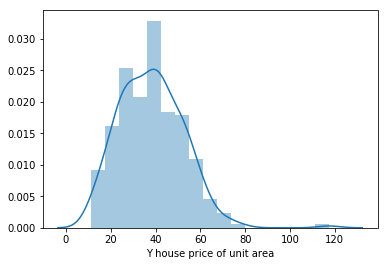

In [8]:
sns.distplot(y_train)

#skewness and kurtosis
print("Skewness: {}".format(y_train.skew()))
print("Kurtosis: {}".format(y_train.kurt()))


* https://scikit-learn.org/stable/modules/preprocessing.html

Target variable 'Y house price of unit area' is not normally distributed. This can reduce the performance of the ML regression models because some models assume normal distribution.

Hence, we make a log transformation.

Skewness: -0.5308642756959739
Kurtosis: 0.12198870635737791


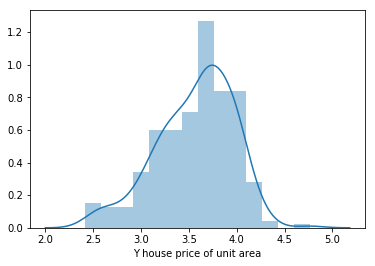

In [9]:
y_train = np.log(y_train)

sns.distplot(y_train)

#skewness and kurtosis
print("Skewness: {}".format(y_train.skew()))
print("Kurtosis: {}".format(y_train.kurt()))


* https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa

<i>Heuristic for skewness:</i>
    
fairly symmetrical : between(-0.5 && <= 0.5)

moderately skewed  : between(-1.0 && -0.5) || between(0.5 && 1.0)

highly skewed      : <-1 || > 1

where -'ve skew is where left side of the distribution is longer and vice versa for +'ve skew

<br>

<i>Kurtosis</i>

the measure of outliers present in the distribution.

Heuristic: -3.0 to 3.0 is acceptable

Hence, the new logged distribution for the target is better.


# Identify features with strong correlation to target

Relation of features to target (Y Housing Price)

In [10]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
# .concat()
# .corr()

# pd.concat([X_train, y_train], axis=1).corr()

df_train = pd.concat([X_train, y_train], axis=1)
df_train.corr()


,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
X1 transaction date,1.000000,-0.032792,0.028306,0.026488,0.100413,-0.023486,0.125001
X2 house age,-0.032792,1.000000,0.011579,0.093652,0.075280,-0.022327,-0.174232
X3 distance to the nearest MRT station,0.028306,0.011579,1.000000,-0.619134,-0.587114,-0.779130,-0.778382
X4 number of convenience stores,0.026488,0.093652,-0.619134,1.000000,0.465927,0.421933,0.602795
X5 latitude,0.100413,0.075280,-0.587114,0.465927,1.000000,0.384123,0.648796
X6 longitude,-0.023486,-0.022327,-0.779130,0.421933,0.384123,1.000000,0.577637
Y house price of unit area,0.125001,-0.174232,-0.778382,0.602795,0.648796,0.577637,1.000000


If I use min correlation acceptable as +-0.4, then variables X3, X4, X5, X6 passed this criteria.
However, I ignore X5 and X6, because longitude in itself or latitude in itself is not meaningful.

It appears that the attributes "X3 distance to the nearest MRT Station" has a strong negative correlation with the target variable "Y house price of unit area". In other words, the further the distance to the nearest MRT, the lower the house price.

X4 has medium positive correlation to the target, i.e. The more the number of convenience stores, the higher the house price.


### scatter plot of high correlation features to check on linearity

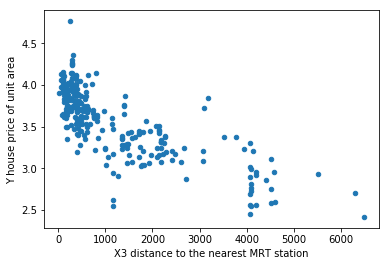

In [11]:
# X3 distance from MRT vs House Price
df_train.plot.scatter(x=x3,y=target)

There are a few outliers and the graph shows a roughly linear negative correlation. It is possible to use linear correlation algorithm, however, we still need to look at the graphs of the other variables.

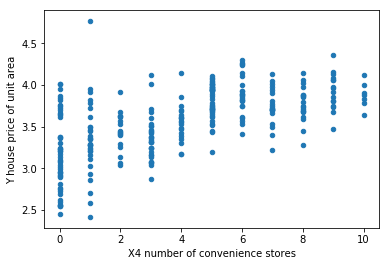

In [12]:
# X4 Number of convenience stores vs House Price
df_train.plot.scatter(x=x4,y=target)

The graph shows a roughly positive linear pattern although there are clear breaks due to the fact that the number of convenience stores is a discrete value. When the number of convenience stores are more, the house price per unit area tends to cluster around a higher price point, positive correlation.

# Feature Engineering
not specific to any machine learning model

### latitude and longitude

In [13]:
print('\nLongtitute and Latitude are meaningful only when used together as a "location".')
print('Hence, I combined "longtitude" and "latitude" into one feature')

df['X5 geoHash'] = df.apply(lambda row: geohash2.encode(row['X5 latitude'],row['X6 longitude']),axis=1)

features = list(df.columns)

features.remove('X5 latitude')
features.remove('X6 longitude')
features.remove('Y house price of unit area')

print('\nAfter creating a geohash for latitude and longitute, the columns of the data frame "df_X"')
print('which is the dataset containing features ONLY is:\n')
df_X = df[features] 
print(df_X.columns)

print('\n\nAnd a sample observation is: \n{}'.format(df_X.sample(1)))

print('\n\nBut in geoHashing latitude and longtitude, I have created a non-numeric categorical column, which may')
print(' not work well with some ML models or require further transformation in order to do so.')



Longtitute and Latitude are meaningful only when used together as a "location".
Hence, I combined "longtitude" and "latitude" into one feature

After creating a geohash for latitude and longitute, the columns of the data frame "df_X"
which is the dataset containing features ONLY is:

Index(['No', 'X1 transaction date', 'X2 house age',
       'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 geoHash'],
      dtype='object')


And a sample observation is: 
      No  X1 transaction date  X2 house age  \
284  285             2012.917          15.0   

     X3 distance to the nearest MRT station  X4 number of convenience stores  \
284                                383.2805                                7   

       X5 geoHash  
284  wsqqjc4j77kk  


But in geoHashing latitude and longtitude, I have created a non-numeric categorical column, which may
 not work well with some ML models or require further transformation in order to do so.


# Box plot

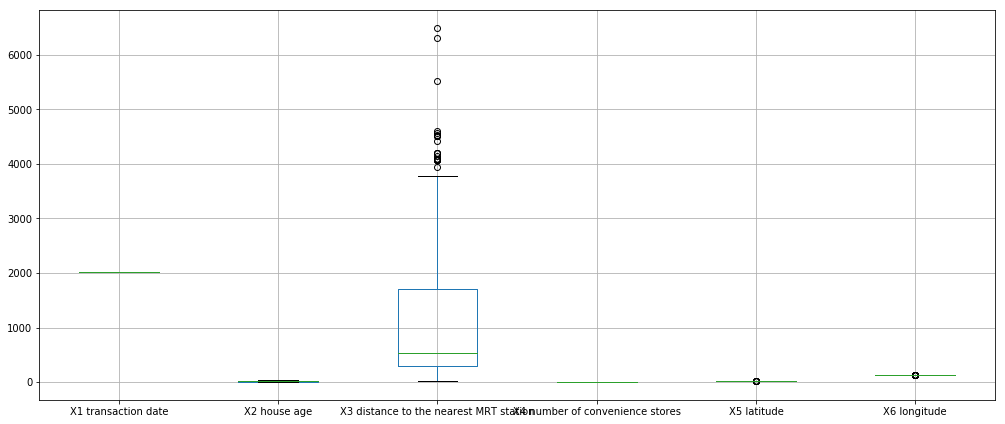

In [14]:
figure, axes = plt.subplots(figsize = (14,6))
plt.tight_layout()
X_train.boxplot()

The range of "X3 Distance to the nearest MRT" is huge compared to the other variables and it is better to scaled all the variables using SKLearn standardscaler() to increase the performance of the Machine Learning model.

### Scaling
As seen by the above box plot, some features can have very different ranges i.e. 0 to 10 (convenience stores) vs 0 to 6000 (distance to mrt), it is better to scale the features.

In [15]:
# Standard Scaler assumes that data is normally distributed

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


# Print the mean and standard deviation of the unscaled features
print('Unscaled')
print('*'*15)
print("Mean of Unscaled Features of X_train: {}".format(np.mean(X_train))) 
print("\nStandard Deviation of Unscaled Features of X_train: {}".format(np.std(X_train)))

features = X_train.columns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features)

print('*'*100)
# Print the mean and standard deviation of the scaled features
print('\nScaled')
print('*'*15)

print("\nMean of Scaled Features of X_train_scaled: {}".format(np.mean(X_train_scaled))) 
print("\nStandard Deviation of Scaled Features of X_train_scaled: {}".format(np.std(X_train_scaled)))



Unscaled
***************
Mean of Unscaled Features of X_train: X1 transaction date                       2013.149534
X2 house age                                17.010108
X3 distance to the nearest MRT station    1153.092988
X4 number of convenience stores              3.981949
X5 latitude                                 24.968888
X6 longitude                               121.532962
dtype: float64

Standard Deviation of Unscaled Features of X_train: X1 transaction date                          0.277300
X2 house age                                11.285493
X3 distance to the nearest MRT station    1294.774376
X4 number of convenience stores              2.966059
X5 latitude                                  0.012734
X6 longitude                                 0.015838
dtype: float64
****************************************************************************************************

Scaled
***************

Mean of Scaled Features of X_train_scaled: X1 transaction date                  